# Feature Engineering Phase
In this notebook I'm implementing all the feature engineering code in order to prepare our dataset for modeling.

**Author**: Arthur G.
***

## Imporing Dependencies
In this first section I'm importing all the dependencies and configurations for the notebook.

In [1]:
# custom dependencies
import sys
sys.path.append('../')

# libs
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from src.data.make_dataset import *
from src.features.build_features import *
from src.visualization.visualize import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# settings
seed = np.random.seed(42)
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', None)

## Loading Dataset
Now I'll load the processed dataset.

In [2]:
df = pd.read_csv(os.path.join('..', 'data', 'interim', 'fuel_consumption_data.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DEPARTURE_ARRIVAL_DURATION  1302 non-null   float64
 1   ARRIVAL_DEPARTURE_DURATION  1302 non-null   float64
 2   STOPOVERS                   1302 non-null   int64  
 3   VESSEL_TYPE                 1302 non-null   object 
 4   HULL_MATERIAL               1302 non-null   object 
 5   VESSEL_LENGTH               1302 non-null   float64
 6   VESSEL_BEAN                 1302 non-null   float64
 7   VESSEL_DRAFT                1302 non-null   float64
 8   VESSEL_DEPTH                1302 non-null   float64
 9   MOTOR_POWER                 1302 non-null   float64
 10  SPEED                       1302 non-null   float64
 11  NUM_PROPELLERS              1302 non-null   int64  
 12  NUM_GENERATORS              1302 non-null   float64
 13  DWT                         552 n

## Dataset Split
The first thing we want to do in the feature engineering phase is to split our dataset into train and test splits. We need to split it at the beginning because a lot of pre-processing objects we gonna use will learn from data parameters such as:
+ mean
+ mode
+ exponents for mathematical transformations
+ category frequency
+ and etc.

In [3]:
# splitting predictors/targets
predictors = df.drop(['FUEL_CONSUMPTION'], axis=1)
targets = df.FUEL_CONSUMPTION

# splitting train/test
x_train, x_test, y_train, y_test = train_test_split(
    predictors,
    targets,
    test_size=0.1,
    random_state=seed,
    shuffle=True
)

# applying log transformation on targets
y_train = np.log(y_train)
y_test = np.log(y_test)

print(f"Train set: {x_train.shape}")
print(f"Test set: {x_test.shape}")

Train set: (1171, 18)
Test set: (131, 18)


## Handling Missing Values
We have two problematic columns with a high amount of missing values, DWT and LIGHT_DISPLACEMENT. Once they're numerical variables, let's implement a binary missing values replacement.

In [4]:
vars_with_nans = ['DWT', 'LIGHT_DISPLACEMENT']

for var in vars_with_nans:
    # calculating the variable mean
    mean_val = x_train[var].mean()
    
    # adding a binary missing indicator (in train and test)
    x_train[var + '_na'] = np.where(x_train[var].isnull(), 1, 0)
    x_test[var + '_na'] = np.where(x_test[var].isnull(), 1, 0)
    
    # filling missing values with the mean
    x_train[var].fillna(mean_val, inplace=True)
    x_test[var].fillna(mean_val, inplace=True)
    
# checking for missing values
train_nulls = x_train.isnull().sum().sum()
test_nulls = x_test.isnull().sum().sum()
print(f"There are a total of {train_nulls + test_nulls} nans in both train and test sets!")

There are a total of 0 nans in both train and test sets!


## Numerical Variable Transformation
In this section I'm transforming the numerical variables based on what we've described in the data analysis notebook.

### Logarithmic Transformation
Let's firts transform variables with log transformation.

In [5]:
log_transformable_vars = ['LIGHT_DISPLACEMENT']

for var in log_transformable_vars:
    x_train[var] = np.log(x_train[var])
    x_test[var] = np.log(x_test[var])

### Yeo-Johnson Transformation
Now I'll transform variables with yeo-johnson transformation.

In [6]:
yeojohnson_transformable_vars = [
    'DEPARTURE_ARRIVAL_DURATION',
    'ARRIVAL_DEPARTURE_DURATION',
    'VESSEL_LENGTH',
    'VESSEL_BEAN',
    'VESSEL_DRAFT',
    'VESSEL_DEPTH',
    'SPEED'
]

for var in yeojohnson_transformable_vars:
    x_train[var], param = stats.yeojohnson(x_train[var])
    x_test[var], param = stats.yeojohnson(x_test[var])

## Data Encoding
In this section I'll be encoding categorical data. Here I'll be transforming string categorical variables into numbers by ranking labels based on the mean FUEL_CONSUMPTION. This way we can encode categorical data in a mathematical meaningful way for the model.

In [7]:
encodable_categorical_vars = ['VESSEL_TYPE', 'HULL_MATERIAL']

for var in encodable_categorical_vars:
    encode_categories(x_train, x_test, y_train, var, 'FUEL_CONSUMPTION')

VESSEL_TYPE {'PASSENGERS': 0, 'OTHER': 1, 'MOTORBOAT': 2, 'FLAT_BOTTOMED_BOAT': 3, 'PASSENGER/GENERAL_LOAD': 4, 'FERRY_BOAT': 5, 'CATAMARAN': 6}
HULL_MATERIAL {'FIBER': 0, 'ALUMINIUM': 1, 'WOOD': 2, 'NAVAL_STEEL': 3}


Now let's analyze the monotonic relationship exposed by the data encoding strategy applied to our categorical variables listed above.

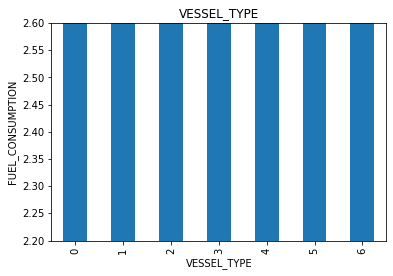

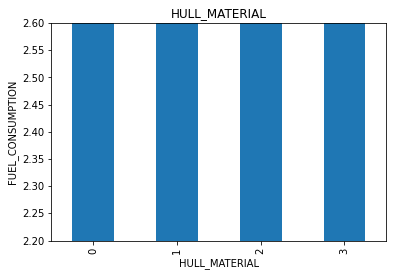

In [15]:
for var in encodable_categorical_vars:
    plot_monotonic_relationship(x_train, y_train, var, 'FUEL_CONSUMPTION')

As the target variable is log transformed, we can't easily see the monotonic relationship (the increase in fuel consumption as the encoded variable increases as well). But we can rest assured that our encoding is mathematically meaningful for the model.

## Feature Scaling
For our data to successfully fit linear models we need our columns to be scaled in the "same unit of measurement". To do this we make use of Scikit-learn's MinMaxScaler.

In [16]:
# creating and fitting the scaler
scaler = MinMaxScaler(feature_range=[0, 1])
scaler.fit(x_train)

# transforming train and test sets
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

x_train.head()

,DEPARTURE_ARRIVAL_DURATION,ARRIVAL_DEPARTURE_DURATION,STOPOVERS,VESSEL_TYPE,HULL_MATERIAL,VESSEL_LENGTH,VESSEL_BEAN,VESSEL_DRAFT,VESSEL_DEPTH,MOTOR_POWER,SPEED,NUM_PROPELLERS,NUM_GENERATORS,DWT,LIGHT_DISPLACEMENT,CREW,PASS_CAPACITY,LOAD_CAPACITY,DWT_na,LIGHT_DISPLACEMENT_na
0,0.387,0.399,0.000,0.833,1.000,0.691,0.643,0.440,0.364,0.088,0.383,0.25,0.4,0.113,0.542,0.381,0.158,0.098,0.0,0.0
1,0.852,0.844,0.091,0.667,0.667,0.494,0.498,0.325,0.364,0.045,0.124,0.25,0.4,0.102,0.558,0.143,0.033,0.109,1.0,1.0
2,0.852,0.862,0.000,0.667,0.667,0.441,0.643,0.325,0.186,0.028,0.792,0.25,0.4,0.102,0.558,0.095,0.025,0.013,1.0,1.0
3,0.603,0.616,0.000,0.667,0.667,0.505,0.445,0.456,0.382,0.106,0.548,0.25,0.4,0.022,0.251,0.238,0.050,0.019,0.0,0.0
4,0.812,0.799,0.000,0.667,0.667,0.303,0.217,0.259,0.213,0.045,0.225,0.00,0.2,0.102,0.558,0.048,0.013,0.000,1.0,1.0


Now let's quickly reorganize our columns before saving the train and test data.

In [18]:
columns_organization = ['DEPARTURE_ARRIVAL_DURATION', 'ARRIVAL_DEPARTURE_DURATION', 'STOPOVERS',
       'VESSEL_TYPE', 'HULL_MATERIAL', 'VESSEL_LENGTH', 'VESSEL_BEAN','VESSEL_DRAFT', 'VESSEL_DEPTH', 
       'MOTOR_POWER', 'SPEED', 'NUM_PROPELLERS', 'NUM_GENERATORS', 'DWT', 'DWT_na', 'LIGHT_DISPLACEMENT', 
       'LIGHT_DISPLACEMENT_na', 'CREW', 'PASS_CAPACITY', 'LOAD_CAPACITY']

x_train = x_train[columns_organization]
x_test = x_test[columns_organization]

x_train.head()

,DEPARTURE_ARRIVAL_DURATION,ARRIVAL_DEPARTURE_DURATION,STOPOVERS,VESSEL_TYPE,HULL_MATERIAL,VESSEL_LENGTH,VESSEL_BEAN,VESSEL_DRAFT,VESSEL_DEPTH,MOTOR_POWER,SPEED,NUM_PROPELLERS,NUM_GENERATORS,DWT,DWT_na,LIGHT_DISPLACEMENT,LIGHT_DISPLACEMENT_na,CREW,PASS_CAPACITY,LOAD_CAPACITY
0,0.387,0.399,0.000,0.833,1.000,0.691,0.643,0.440,0.364,0.088,0.383,0.25,0.4,0.113,0.0,0.542,0.0,0.381,0.158,0.098
1,0.852,0.844,0.091,0.667,0.667,0.494,0.498,0.325,0.364,0.045,0.124,0.25,0.4,0.102,1.0,0.558,1.0,0.143,0.033,0.109
2,0.852,0.862,0.000,0.667,0.667,0.441,0.643,0.325,0.186,0.028,0.792,0.25,0.4,0.102,1.0,0.558,1.0,0.095,0.025,0.013
3,0.603,0.616,0.000,0.667,0.667,0.505,0.445,0.456,0.382,0.106,0.548,0.25,0.4,0.022,0.0,0.251,0.0,0.238,0.050,0.019
4,0.812,0.799,0.000,0.667,0.667,0.303,0.217,0.259,0.213,0.045,0.225,0.00,0.2,0.102,1.0,0.558,1.0,0.048,0.013,0.000


## Serializing Data and Transformations
Here I'll be serializing the transformed train and test sets as well as the scaler.

In [19]:
# serializing train and test sets
x_train.to_csv(os.path.join('..', 'data', 'processed', 'x_train.csv'), index=False)
x_test.to_csv(os.path.join('..', 'data', 'processed', 'x_test.csv'), index=False)

y_train.to_csv(os.path.join('..', 'data', 'processed', 'y_train.csv'), index=False)
y_test.to_csv(os.path.join('..', 'data', 'processed', 'y_test.csv'), index=False)

# serializing the scaler
joblib.dump(scaler, os.path.join('..', 'models', 'minmax_scaler.joblib'))

['../models/minmax_scaler.joblib']

Now we're finished with our feature engineer phase.